# MAR6669 - Customer Churn Model and Logistic Regression

### Warington College of Business

This notebook will illustrate building an end-to-end Customer Churn Model using logistic regression. The model incoporates pipelines and also includes hyperparameter tuning at the end. We will use the outcomes from this model in the next session as we identify customer lifetime value metrics to incorporate into an intervention to prevent customer churn.

In [63]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score
#from plotnine import *
#from plotnine.data import *

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from plot_metric.functions import BinaryClassification # pip install plot-metric

import warnings
warnings.filterwarnings("ignore")

In [64]:
mydata = pd.read_csv("Telco-Customer-Churn.csv")
orig_df = mydata

In [65]:
mydata.shape

(7043, 21)

In [66]:
mydata.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [67]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [68]:
mydata.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [69]:
# found values with ' ' in the TotalCharges field
mydata['TotalCharges'] = mydata['TotalCharges'].replace(' ', np.nan).astype(float)

In [70]:
# converting the TotalCharges column to a number 
mydata['TotalCharges'].astype('double')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [71]:
# drop the missing values rows from the data frame
mydata = mydata.dropna()

In [72]:
mydata.shape
# how many rows were removed?

(7032, 21)

In [73]:
# create a backup copy of the modified dataset
backup_df = mydata

In [74]:
# the target variable needs to be encoded
mydata['Churn'] = mydata['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [75]:
# what percentage of the customers churned in the last month?
mydata['Churn'].mean()

0.26578498293515357

In [76]:
mydata.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [77]:
mydata[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


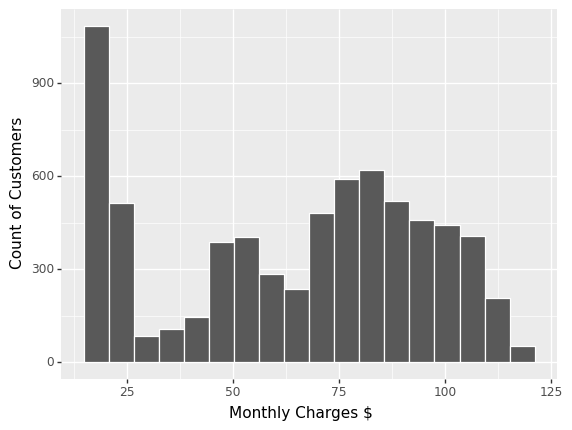

<ggplot: (8764243006711)>

In [78]:
# plot a histogram of MonthlyCharges using PlotNine
# https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_histogram.html
(
    ggplot(mydata, aes(x='MonthlyCharges'))
    + geom_histogram(color='white')
    + labs(y="Count of Customers", x = "Monthly Charges $")
)

In [79]:
# modify the MonthlyCharges by transforming to a log and then normalizing the variable (feature)
mydata['logMonthlyCharges'] = np.log(mydata['MonthlyCharges'])
mydata['logMonthlyChargesNorm'] = (mydata['logMonthlyCharges'] - 
                                   mydata['logMonthlyCharges'].mean())/mydata['logMonthlyCharges'].std()

In [80]:
# modify the tenure by transforming to a log and then normalizing the variable (feature)
mydata['logtenure'] = np.log(mydata['tenure'])
mydata['logtenureNorm'] = (mydata['logtenure'] - 
                                   mydata['logtenure'].mean())/mydata['logtenure'].std()

In [81]:
# modify the TotalCharges by transforming to a log and then normalizing the variable (feature)
mydata['logTotalCharges'] = np.log(mydata['TotalCharges'])
mydata['logTotalChargesNorm'] = (mydata['logTotalCharges'] - 
                                   mydata['logTotalCharges'].mean())/mydata['logTotalCharges'].std()

In [82]:
# fix the senior citizen feature to be a categorical variable
mydata['SeniorCitizen'] = mydata['SeniorCitizen'].apply(lambda x: "Senior" if x==1 else "NotSC")

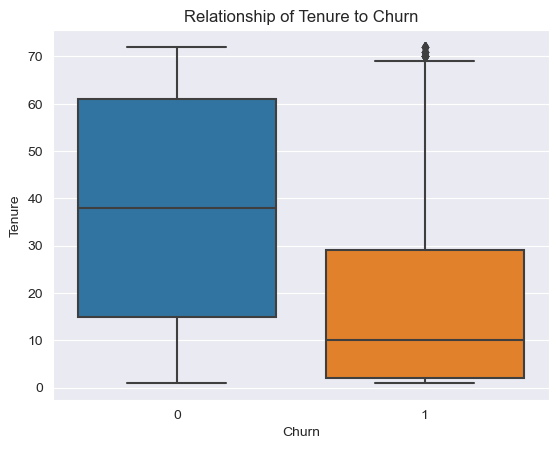

In [83]:
# create boxplots to illustrate the relationships between the numeric variables and the 
# target variable
sns.boxplot( y=mydata["tenure"], x=mydata["Churn"] );
plt.xlabel("Churn")
plt.ylabel("Tenure")
plt.title("Relationship of Tenure to Churn")
plt.show()

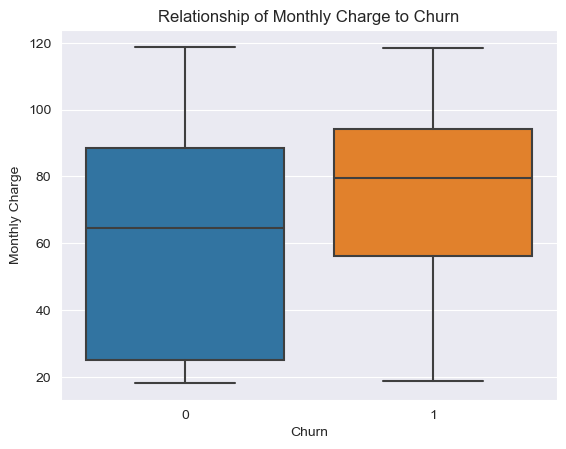

In [84]:
# Monthly charge
sns.boxplot( y=mydata["MonthlyCharges"], x=mydata["Churn"] );
plt.xlabel("Churn")
plt.ylabel("Monthly Charge")
plt.title("Relationship of Monthly Charge to Churn")
plt.show()

In [85]:
mydata.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,logMonthlyCharges,logMonthlyChargesNorm,logtenure,logtenureNorm,logTotalCharges,logTotalChargesNorm
0,7590-VHVEG,Female,NotSC,Yes,No,1,No,No phone service,DSL,No,...,Electronic check,29.85,29.85,0,3.396185,-1.054244,0.000000,-2.202244,3.396185,-2.281382
1,5575-GNVDE,Male,NotSC,No,No,34,Yes,No,DSL,Yes,...,Mailed check,56.95,1889.50,0,4.042174,0.032896,3.526361,0.459254,7.544068,0.389269
2,3668-QPYBK,Male,NotSC,No,No,2,Yes,No,DSL,Yes,...,Mailed check,53.85,108.15,1,3.986202,-0.061298,0.693147,-1.679096,4.683519,-1.452520
3,7795-CFOCW,Male,NotSC,No,No,45,No,No phone service,DSL,Yes,...,Bank transfer (automatic),42.30,1840.75,0,3.744787,-0.467578,3.806662,0.670810,7.517928,0.372439
4,9237-HQITU,Female,NotSC,No,No,2,Yes,No,Fiber optic,No,...,Electronic check,70.70,151.65,1,4.258446,0.396862,0.693147,-1.679096,5.021575,-1.234860


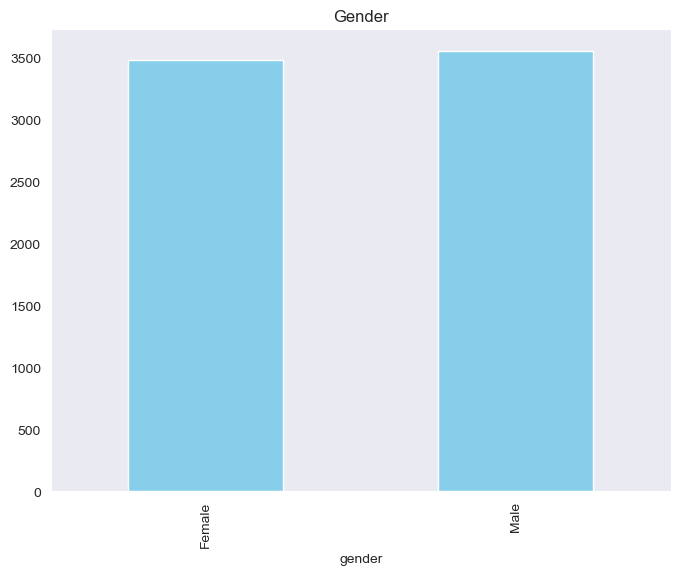

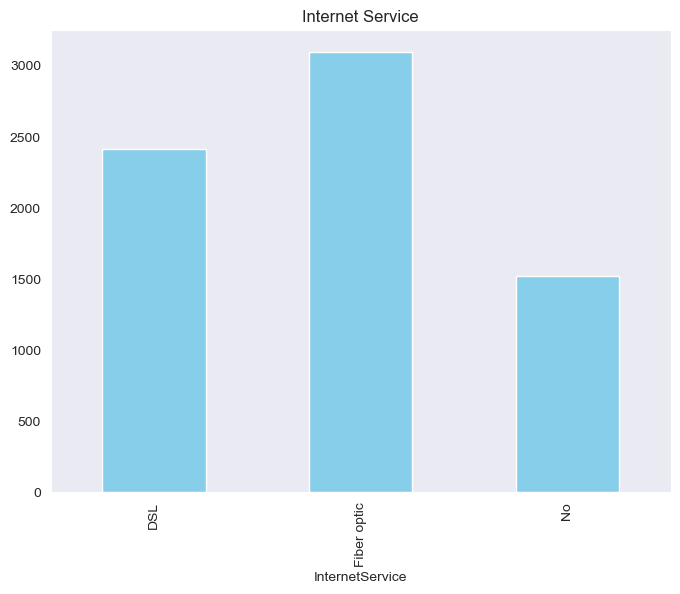

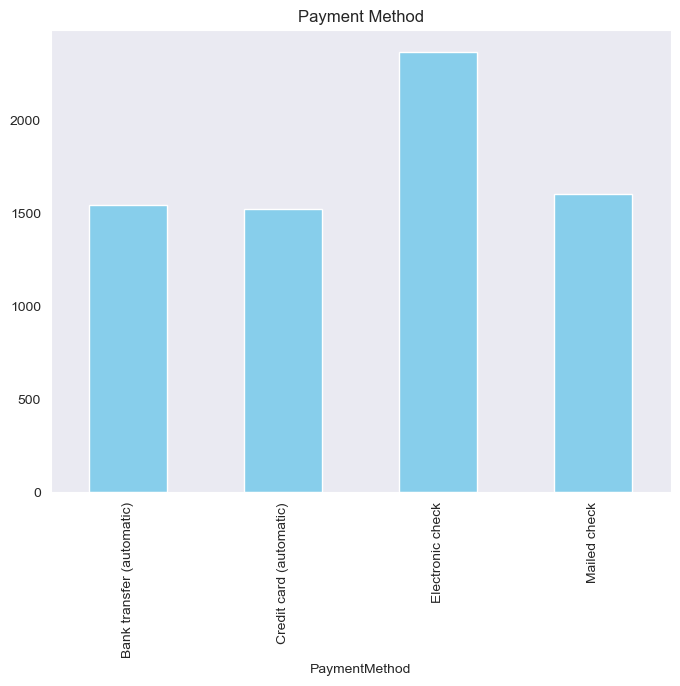

In [86]:
# visualize some of these distributions of categorical variables
mydata.groupby('gender').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Gender'
)
plt.grid(False)
plt.show()

mydata.groupby('InternetService').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Internet Service'
)
plt.grid(False)
plt.show()

mydata.groupby('PaymentMethod').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Payment Method'
)
plt.grid(False)
plt.show()

In [87]:
# restore the state of the data frame before analysis
dropCols = ['customerID', 'logMonthlyCharges','logMonthlyChargesNorm','logtenure','logtenureNorm',
           'logTotalCharges','logTotalChargesNorm']
model_df = mydata.drop(dropCols, axis = 1)
model_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,NotSC,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,NotSC,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,NotSC,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,NotSC,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,NotSC,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [88]:
# as we transform variables, we want to convert the categorical variables
# the first step is to identify variables we want to convert
# In Python, this is known as One-Hot Encoding
for col in list(model_df.columns):
    print(col, model_df[col].nunique())

gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 72
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1584
TotalCharges 6530
Churn 2


In [89]:
# this next set of code sets up some important features of the dataset
# it also includes code that identifies features by type (categorical or numerical)
SEED = 365
TARGET = 'Churn'
FEATURES = model_df.columns.drop(TARGET)

NUMERICAL = model_df[FEATURES].select_dtypes('number').columns
print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL))
print(f"Categorical features: {', '.join(CATEGORICAL)}")

Numerical features: tenure, MonthlyCharges, TotalCharges
Categorical features: Contract, Dependents, DeviceProtection, InternetService, MultipleLines, OnlineBackup, OnlineSecurity, PaperlessBilling, Partner, PaymentMethod, PhoneService, SeniorCitizen, StreamingMovies, StreamingTV, TechSupport, gender


In [90]:
model_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,NotSC,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,NotSC,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,NotSC,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,NotSC,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,NotSC,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [91]:
# this section of code will set up the data for prediction correctly
# it will first separate the data into train / test
# then it will use the train data to transform categorical data and fill in missing data
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(columns=TARGET), model_df[TARGET], 
                                                    test_size=.2, random_state=SEED, 
                                                    stratify=model_df[TARGET])
num_imputer = SimpleImputer(strategy='mean')
train_num_imputed = num_imputer.fit_transform(X_train[NUMERICAL])

scaler = MinMaxScaler()
train_num_scaled = scaler.fit_transform(train_num_imputed)

cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train_cat_imputed = cat_imputer.fit_transform(X_train[CATEGORICAL])

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
train_cat_encoded = encoder.fit_transform(train_cat_imputed)

train_preprocessed = np.concatenate((train_num_scaled, train_cat_encoded), axis=1)

columns = np.append(NUMERICAL, encoder.get_feature_names_out(CATEGORICAL))
pd.DataFrame(train_preprocessed, columns=columns, index=X_train.index).head()

,tenure,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,Dependents_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,InternetService_Fiber optic,InternetService_No,...,PaymentMethod_Mailed check,PhoneService_Yes,SeniorCitizen_Senior,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No internet service,StreamingTV_Yes,TechSupport_No internet service,TechSupport_Yes,gender_Male
848,1.000000,0.733831,0.780447,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
4866,0.211268,0.445771,0.120961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3019,0.295775,0.367164,0.137001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2923,0.746479,0.711940,0.536372,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
380,0.563380,0.676119,0.383135,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [92]:
num_imputer = SimpleImputer(strategy='mean')
test_num_imputed = num_imputer.fit_transform(X_test[NUMERICAL])

scaler = MinMaxScaler()
test_num_scaled = scaler.fit_transform(test_num_imputed)

cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
test_cat_imputed = cat_imputer.fit_transform(X_test[CATEGORICAL])

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
test_cat_encoded = encoder.fit_transform(test_cat_imputed)

test_preprocessed = np.concatenate((test_num_scaled, test_cat_encoded), axis=1)


In [93]:
# Set up a logistic regression model type to train
# Logistic regression is frequently used for categorical modeling. It can serve as a baseline model to
# compare other non-transparent classification models against.
model = LogisticRegression()
model.fit(train_preprocessed, y_train)

probs = model.predict_proba(test_preprocessed)[:,-1]
predictions = model.predict(test_preprocessed)


In [96]:
# This section sets up a metric (AUC) function  to use to assess the model and to compare between models.
def calculate_roc_auc(model_pipe, X, y):
    """Calculate roc auc score. 
    
    Parameters:
    ===========
    model_pipe: sklearn model or pipeline
    X: features
    y: true target
    """
    y_proba = model_pipe.predict_proba(X)[:,1]
    return roc_auc_score(y, y_proba)

In [97]:
# The test data needs to be preprocessed the same way 
# then caluclate area under the curve for both the training and test data
test_num_imputed = num_imputer.transform(X_test[NUMERICAL])
test_num_scaled = scaler.transform(test_num_imputed)
test_cat_imputed = cat_imputer.transform(X_test[CATEGORICAL])
test_cat_encoded = encoder.transform(test_cat_imputed)
test_preprocessed = np.concatenate((test_num_scaled, test_cat_encoded), axis=1)

print(f"Train ROC-AUC: {calculate_roc_auc(model, train_preprocessed, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(model, test_preprocessed, y_test):.4f}")

Train ROC-AUC: 0.8474
Test ROC-AUC: 0.8462


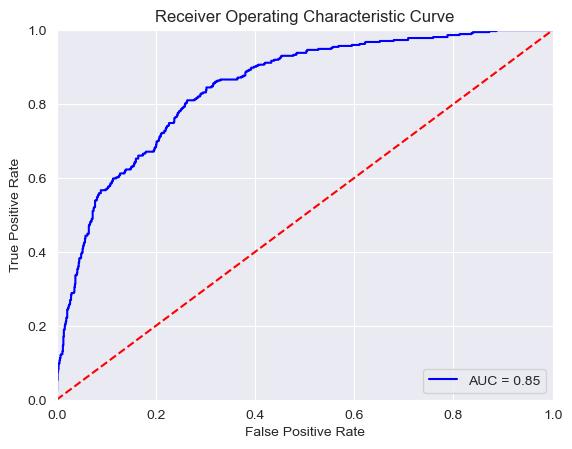

In [98]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
import sklearn
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

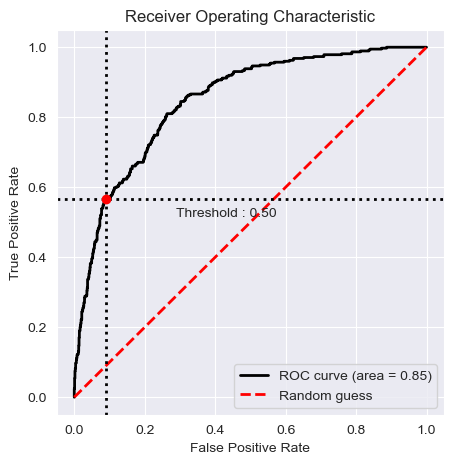

In [35]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
# Visualisation with plot_metric
bc = BinaryClassification(y_test, probs, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [99]:
# create the confusion matrix for the model
# Actuals are on the horizontal... Predictions are on the vertical
confusion_matrix(y_test, predictions)

array([[938,  95],
       [162, 212]])

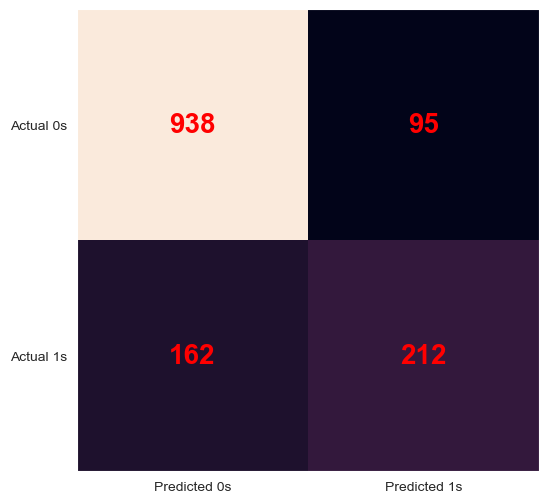

In [100]:
# illustrate the confusion matrix
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red', weight = 'bold', fontsize = 20)
plt.show()

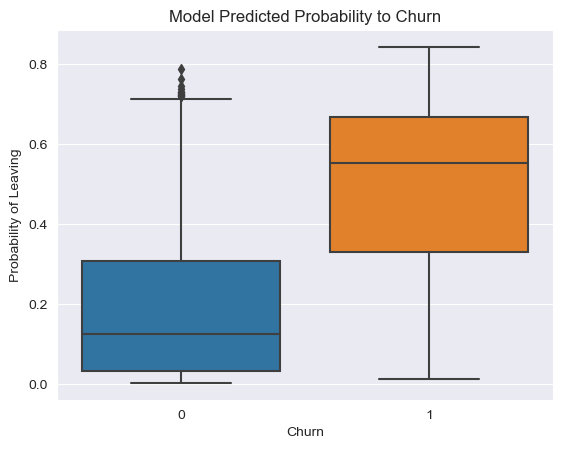

In [101]:
# Churn comparison
sns.boxplot (y=probs, x=y_test);
plt.xlabel("Churn")
plt.ylabel("Probability of Leaving")
plt.title("Model Predicted Probability to Churn")
plt.show()

In [102]:
# other key metrics
# https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3

predictions_test = predictions
accuracy_test = accuracy_score(y_test, predictions_test)
predictions_train = model.predict(train_preprocessed)
accuracy_train = accuracy_score(y_train, predictions_train)
print("Train accuracy is = ", accuracy_train)
print("Test accuracy is = ", accuracy_test)

Train accuracy is =  0.8037333333333333
Test accuracy is =  0.8173418621179815
